<h1 style="text-align:center; font-size:40px;">Birds Classification Project</h1>
<h2 style="text-align:center; font-size:20px;">Explore 525 Different Species</h2>
<p style="text-align: center"><img src="https://github.com/OdedReg/Birds-Classification/blob/main/Birds.jpg?raw=true"></p>

In [1]:
! pip install -U neptune-client lightning --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.34.92 which is incompatible.


In [2]:
import neptune
import pandas as pd
import numpy as np
import os
from PIL import Image
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as L
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision.io import read_image
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary, EarlyStopping
import torch.optim as optim
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import torch.utils.data as data
from torch.utils.data import Dataset,DataLoader, random_split
from tqdm import tqdm
import xgboost as xgb
import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.*")

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/


In [3]:
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "logs")
# Function for setting the seed
L.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [5]:
file_path = "/kaggle/input/100-bird-species/birds.csv"
df = pd.read_csv(file_path)
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


## Preprocessing

In [6]:
# Change 'PARAKETT  AKULET' to the correct label 'PARAKETT  AUKLET'
df['labels'] = df['labels'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET')
df['filepaths'] = df['filepaths'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET')
df.loc[df['data set'] == 'valid', 'filepaths'] = df.loc[df['data set'] == 'valid', 'filepaths'].str.replace('PARAKETT  AUKLET', 'PARAKETT AUKLET')

# Concat Local Dataset path with filepaths
df['filepaths'] = '/kaggle/input/100-bird-species/' + df['filepaths']

# Labels transform to integers
df['class'] = df['class id'].astype(int)

# Splitting df to train, val and tesst
train_df = df[df['data set'] == 'train']
val_df = df[df['data set'] == 'valid'] 
test_df = df[df['data set'] == 'test']

In [7]:
df.head()

,class id,filepaths,labels,data set,scientific name,class
0,0.0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,0
1,0.0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,0
2,0.0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,0
3,0.0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,0
4,0.0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI,0


# Part 1

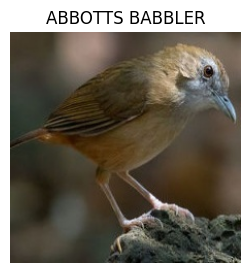

In [60]:
def plot_image_example(index):
    """
    Display an example image from a DataFrame along with its associated label.

    Parameters:
        index (int): The index of the example image in the DataFrame.

    Returns:
        None
    """
    path = df.iloc[index]['filepaths']
    example_type = df.iloc[index]['labels']
    img_example = Image.open(os.path.join(path))
    plt.figure(figsize=(4, 3))
    plt.imshow(img_example)
    plt.title(example_type)
    plt.axis('off')  # Turn off axis
    plt.show()
    
plot_image_example(12)

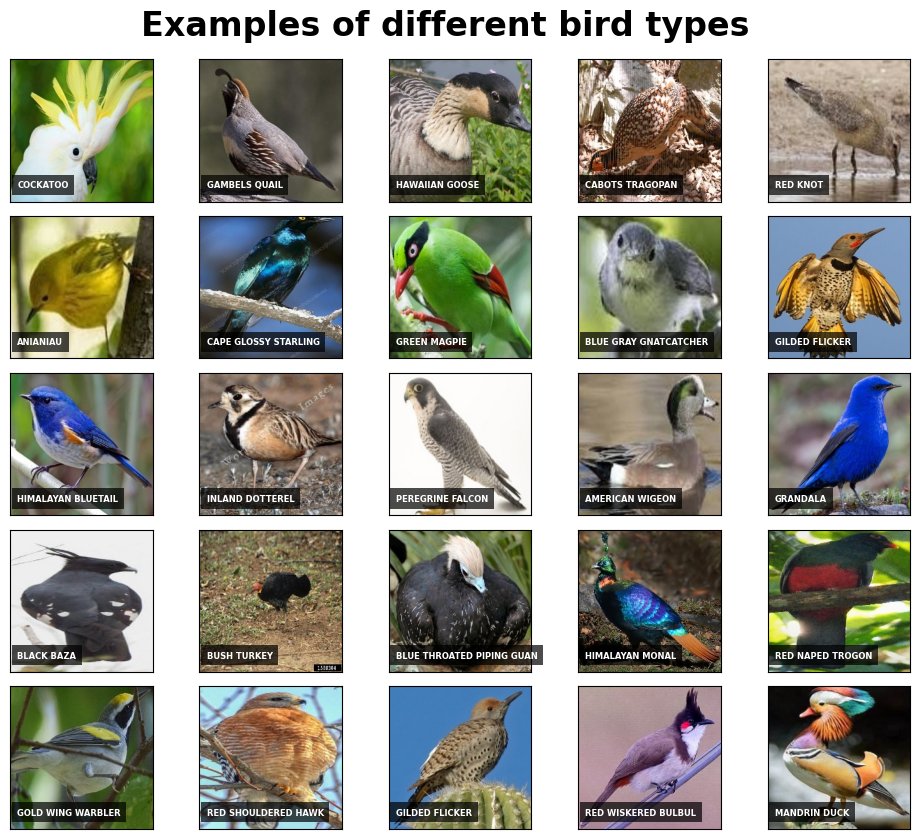

In [93]:
def plot_multiple_imgs(df, title, nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    """
    Plot multiple images from a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing image paths and labels.
        nrow (int): Number of rows in the grid of images.
        ncol (int): Number of columns in the grid of images.
        figsize (tuple): Size of the entire figure.
        preds (list, optional): List of predictions for the images. Default is None.
        skip (int, optional): Number of initial rows to skip in the DataFrame. Default is 0.

    Returns:
        None
    """
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    if title:
        fig.suptitle(title, fontsize=24, fontweight='bold', y=0.93)
    for i in range(nrow*ncol):
        img = Image.open(df.iloc[i, 1])
        ax[i//ncol,i%ncol].imshow(img,cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        ax[i//ncol,i%ncol].text(0.05, 0.1, str(df.iloc[i, 2]), color='white',transform=ax[i//ncol,i%ncol].transAxes,weight='bold', fontsize=6,  bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))
    plt.show()

random_images = df.sample(25, random_state=45)
plot_multiple_imgs(random_images, "Examples of different bird types", 5,5,(12,10))

### a. Dimensionality of the data

In [18]:
print(f'Shape of the dataframe: {df.shape}\n')

split_values = df['data set'].value_counts()
path = df.iloc[0]['filepaths']
img_example = Image.open(os.path.join(path))
width, height = img_example.size

print('X_train shape is: {} \n\
y_train shape is: {}'.format((split_values['train'], width, height ),(split_values['train'], )))
print()
print('X_val shape is: {} \n\
y_val shape is: {}'.format((split_values['valid'], width, height ),(split_values['valid'], )))
print()
print('X_test shape is: {} \n\
y_test shape is: {}'.format((split_values['test'], width, height ),(split_values['test'], )))

Shape of the dataframe: (89885, 6)

X_train shape is: (84635, 224, 224) 
y_train shape is: (84635,)

X_val shape is: (2625, 224, 224) 
y_val shape is: (2625,)

X_test shape is: (2625, 224, 224) 
y_test shape is: (2625,)


### b.	What data does each sample contain?
    

In [64]:
mode= img_example.mode,  # Color mode (e.g., 'RGB')
size = img_example.size,  # Dimensions (width x height)
n_labels = df['labels'].nunique()
print(f'Each image has {mode[0]} mode, size of {size[0]} and one label out of {n_labels}')

Each image has RGB mode, size of (224, 224) and one label out of 525


### c. Class distribution

In [36]:
labels = train_df['labels']
label_counts = labels.value_counts()
n_birds = len(label_counts)
print(f'There are {n_birds} bird species in the dataset\n')
print(f'Labels count:\n\n {label_counts}')

There are 525 bird species in the dataset

Labels count:

 labels
RUFOUS TREPE               263
HOUSE FINCH                248
D-ARNAUDS BARBET           233
OVENBIRD                   233
ASIAN GREEN BEE EATER      220
                          ... 
NORTHERN RED BISHOP        130
SNOWY PLOVER               130
PATAGONIAN SIERRA FINCH    130
EURASIAN GOLDEN ORIOLE     130
RED TAILED THRUSH          130
Name: count, Length: 525, dtype: int64


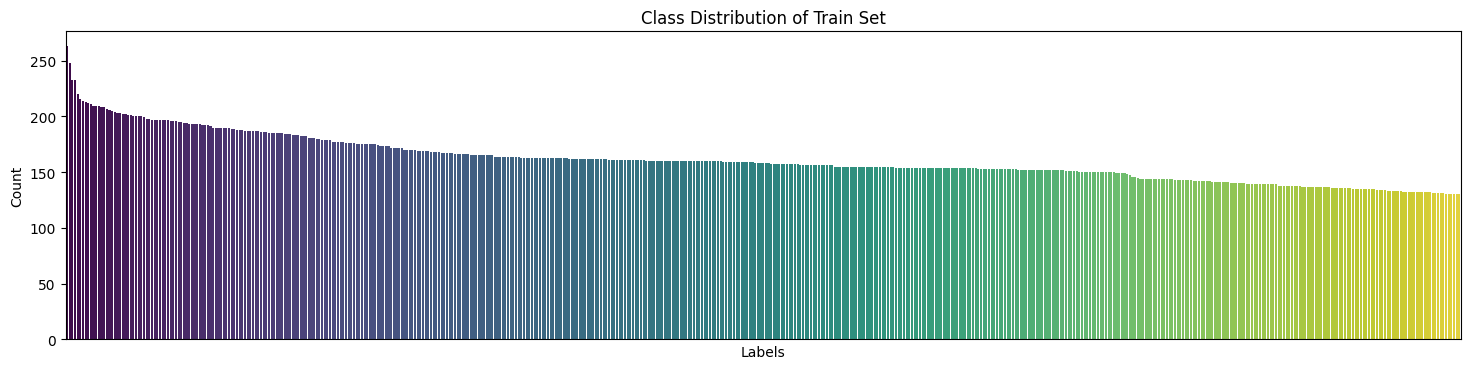

In [20]:
def get_class_dist(df, title):

    labels = df['labels']
    label_counts = labels.value_counts()

    plt.figure(figsize=(18, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', linewidth=0.1)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks([])
    plt.show()
    
# Class Distribution of Train
get_class_dist(train_df, 'Class Distribution of Train Set')

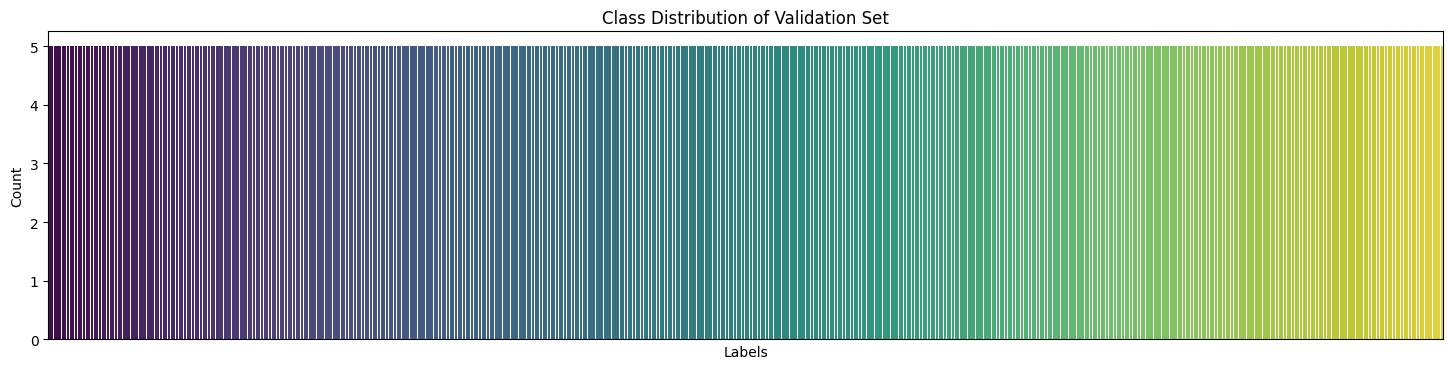

In [21]:
# Class Distribution of validation
get_class_dist(val_df, 'Class Distribution of Validation Set')

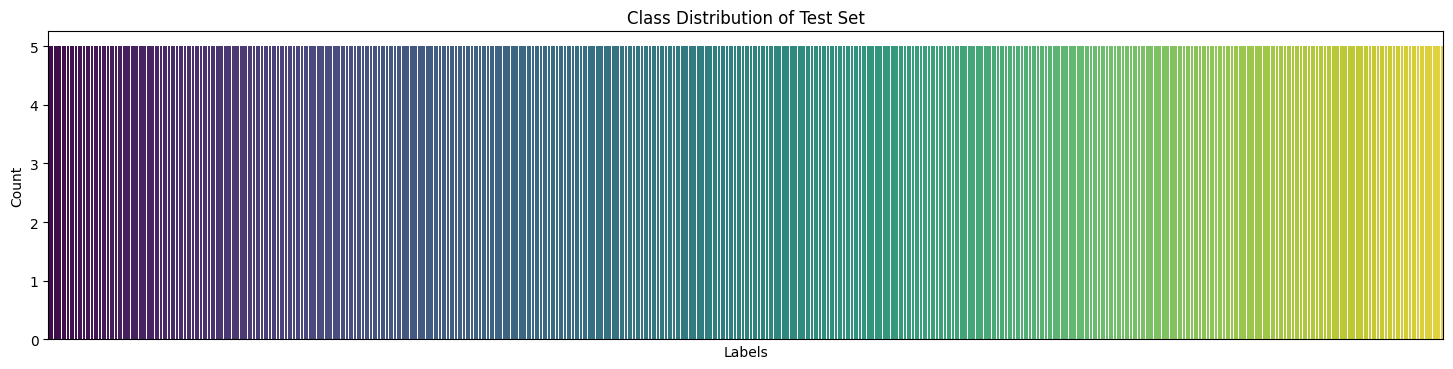

In [68]:
# Class Distribution of Test
get_class_dist(test_df, 'Class Distribution of Test Set')

The graph depict a balanced distribution in the validation and test set.

I will attempt to balance the train set by employing undersampling. Each type of bird will be represented by 130 different images for training, which constitutes a substantial amount.

### d. Benchmark

A benchmark of 99% accuracy has been achieved through transfer learning.

### e. Comparing hardly and easily separable bird species

#### Hardly separable

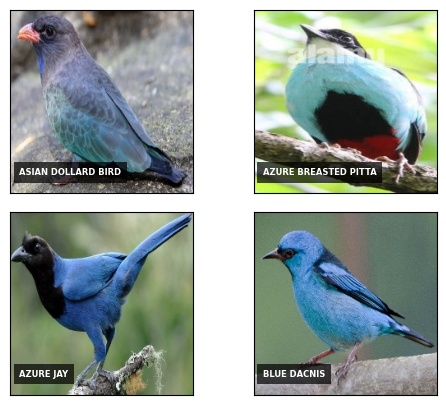

In [95]:
birds_to_show = random_samples_from_each_label(df,1)
birds_to_show = birds_to_show[birds_to_show['labels'].isin(['AZURE BREASTED PITTA', 'AZURE JAY', 'ASIAN DOLLARD BIRD', 'BLUE DACNIS'])]
plot_multiple_imgs(birds_to_show, False, 2,2,(6,5))

### Easily separable

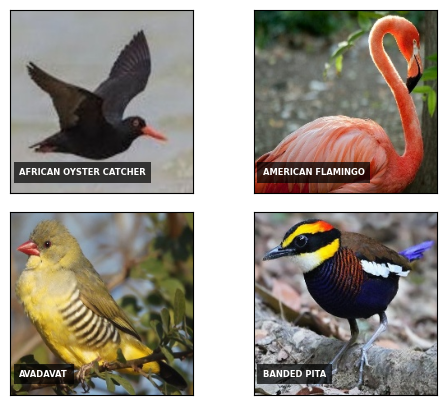

In [ ]:
birds_to_show = random_samples_from_each_label(df,1)
birds_to_show = birds_to_show[birds_to_show['labels'].isin(['AFRICAN OYSTER CATCHER', 'AVADAVAT', 'AMERICAN FLAMINGO','BARN OWL'])]
plot_multiple_imgs(birds_to_show,2,2,(6,5))

### f. Augmentation

#### Calculate mean and std

In [131]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.df)

In [164]:
def get_mean_and_std(dataloader):
    """
    Calculate the mean and standard deviation of pixel values in the dataset.

    Parameters:
        dataloader (DataLoader): A PyTorch DataLoader containing the dataset.

    Returns:
        tuple: A tuple containing the mean and standard deviation of pixel values.
    """
    # placeholders
    psum = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs, labels in tqdm(dataloader):
        psum += inputs.sum(axis=[0, 2, 3])
        psum_sq += (inputs**2).sum(axis=[0, 2, 3])
        
    # pixel count
    count = len(df) * 224 * 224

    # mean and std
    total_mean = psum / count
    total_var = (psum_sq / count) - (total_mean**2)
    total_std = torch.sqrt(total_var)

    return total_mean, total_std
        
        
mean_std_df = df[['filepaths', 'class']]
mean_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_dataset = BirdsDataset(mean_std_df, mean_transform)
image_loader  = DataLoader(image_dataset, batch_size=64, shuffle=False)
mean, std = get_mean_and_std(image_loader)
print("Mean: " + str(mean))
print("STD:  " + str(std))

100%|██████████| 1405/1405 [15:41<00:00,  1.49it/s]

Mean: tensor([0.4742, 0.4694, 0.3954])
STD:  tensor([0.2394, 0.2332, 0.2547])


In [166]:
# Define a list of augmentations
DATA_MEANS = [0.4742, 0.4694, 0.3954]
DATA_STD = [0.2394, 0.2332, 0.2547]

train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  
            transforms.RandomRotation(degrees=15),  
            transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0), ratio=(0.9, 1.1)), 
            transforms.ToTensor(),  
            transforms.Normalize(DATA_MEANS, DATA_STD)
        ])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)])

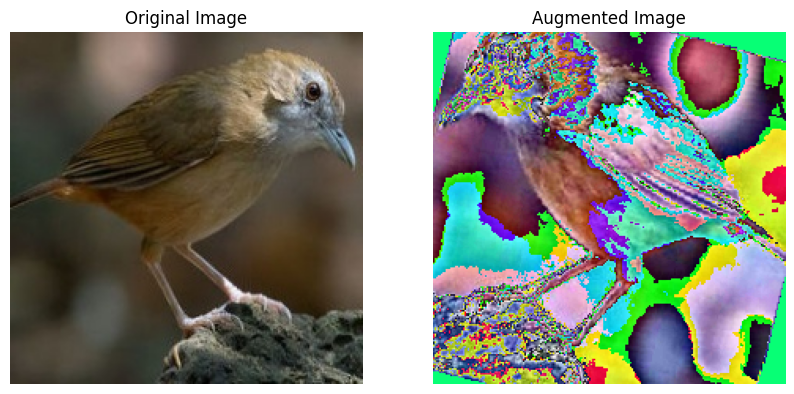

In [178]:
# Display original image vs augmented image
path = df.iloc[12]['filepaths']
img_example = Image.open(os.path.join(path))
augmented_image = train_transform(img_example)

augmented_image_np = TF.to_pil_image(augmented_image)

# Display the original and augmented images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_example)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(augmented_image_np)
axes[1].set_title('Augmented Image')
axes[1].axis('off')

plt.show()

# Part 2 - CNN

In [8]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.df)

In [9]:
class BirdsDataModule(L.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_df = train_data
        self.val_df = val_data
        self.test_df = test_data
        self.batch_size = batch_size
        self.DATA_MEANS = [0.4742, 0.4694, 0.3954]
        self.DATA_STD = [0.2394, 0.2332, 0.2547]
        self.img_size = (224,224)
        
        # Define a list of augmentations
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  
            transforms.RandomRotation(degrees=15),  
            transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0), ratio=(0.9, 1.1)), 
            transforms.ToTensor(),  
            transforms.Normalize(self.DATA_MEANS, self.DATA_STD)
        ])

        self.test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(self.DATA_MEANS, self.DATA_STD)])

    def train_dataloader(self):
        train_dataset = BirdsDataset(self.train_df, self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        val_dataset = BirdsDataset(self.val_df, self.test_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        test_dataset = BirdsDataset(self.test_df, self.test_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)

In [10]:
class CNN(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        self.num_classes = model_hparams['num_classes']
        self.dropout = model_hparams['dropout']
        self.model_name = model_hparams['model_name']
        
        if self.model_name == 'ResNet34':
            self.features = torchvision.models.resnet34(pretrained=True)
            self.features = self.freeze_layers(self.features)
            self.features.fc = nn.Linear(self.features.fc.in_features, self.num_classes)
        elif self.model_name == 'DenseNet121':
            self.features = torchvision.models.densenet121(pretrained=True)
            self.features = self.freeze_layers(self.features)
            self.features.classifier = nn.Linear(self.features.classifier.in_features, self.num_classes)
        elif self.model_name == 'GoogleNet':
            self.features = torchvision.models.googlenet(pretrained=True)
            self.features = self.freeze_layers(self.features)
            self.features.fc = nn.Linear(self.features.fc.in_features, self.num_classes)
            
        else:   # Regular CNN
            self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(self.dropout),
            )
        
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512, self.num_classes)
        
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()

    def freeze_layers(self, model):
        # Freeze all layers except the last one
        for param in model.parameters():
            param.requires_grad = False
        if self.model_name != 'DenseNet121':
            for param in model.fc.parameters():
                param.requires_grad = True
        else:
            for param in model.classifier.parameters():
                param.requires_grad = True
        return model
    
    def forward(self, x):
        x = self.features(x)
        if self.model_name == 'CNN':
            x = self.avgpool(x)
            x = torch.flatten(x,1)
            x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)
        
    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]

In [11]:
def train_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss")

    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=4,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )

    neptune_logger = NeptuneLogger(
    project="odedreg/Assignment3",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMjQ4YmQ0NS02ODcwLTQ2MjEtYTk5OS0zYTAzYTA1ZDViNTUifQ==",
    log_model_checkpoints=False,
    )

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate

    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)

    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CNN.load_from_checkpoint(cp_path)
    else:
        model = CNN(**kwargs)

    dm = BirdsDataModule(train_df, val_df, test_df, batch_size=batch_size)
    trainer.fit(model, dm)

    model = CNN.load_from_checkpoint(
          trainer.checkpoint_callback.best_model_path
      )  # Load best checkpoint after training

    # Test best model on validation and test set

    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test_loss": test_result[0]["test_loss"], "val_loss": val_result[0]["test_loss"],
             "test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [12]:
def test_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model(
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
    torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [13]:
def get_params_list(dropout_list, lr_list, weight_decay_list):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for dropout_value in dropout_list:
        for lr_value in lr_list:
            for weight_decay_value in weight_decay_list:
                  params_list.append(({'num_classes': 525,
                                       'model_name': 'CNN',
                                        'dropout' : dropout_value},
                                      "Adam",
                                      {"lr": lr_value,
                                       "weight_decay": weight_decay_value}))
    return params_list

In [14]:
def grid_search(params_list, X_train_grid, X_val_grid, X_test_grid, model_name, batch_size, max_epochs):
    """
    Perform grid search over the provided parameter combinations.

    Args:
    - params_list (list): List of parameter combinations, each containing model hyperparameters,
    optimizer name, and optimizer hyperparameters.
    - max_epochs (int): Maximum number of epochs for training.

    Returns:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    hyper_params_list = []
    for config in params_list:
        model_hparams = config[0]
        optimizer_name = config[1]
        optimizer_hparams = config[2]
        chosen_model, model_results, cp_path_new, total_time = test_model(
        model_name = model_name,
        cp_path = None,
        batch_size = batch_size,
        max_epochs = max_epochs,
        train_df = X_train_grid,
        val_df = X_val_grid,
        test_df = X_test_grid,
        model_hparams = model_hparams,
        optimizer_name = optimizer_name,
        optimizer_hparams = optimizer_hparams,
        )
        acc_results_val = model_results['val']
        hyper_params_list.append((f"params:\n{model_hparams}\n{optimizer_hparams},  validation loss: {np.round(acc_results_val,3)}\n", np.round(acc_results_val,3)))
    return hyper_params_list

In [15]:
def print_grid_search(hyper_params_list):
    """
    Print the results of the grid search and the best hyperparameters found.

    Args:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    best_hyper_params = min(hyper_params_list, key=lambda item: item[1])[0]
    print(f'\nBest hyperparameters: {best_hyper_params}\n')
    print('Grid Search results:')
    for x in hyper_params_list:
        print(x[0])

In [16]:
def print_results(results):
    """
    Print model results.

    Args:
        results (dict): A dictionary containing model results with keys:
                        - 'test_loss': Test loss value
                        - 'test_acc': Test accuracy value
    Returns:
        None
    """
    print("Model Results:\n")
    print("Test Loss:", results.get('test_loss'))
    print("Test Accuracy:", results.get('test_acc'))


In [17]:
def sample_or_duplicate(group, n_samples):
    """
    Sample or duplicate rows within a group to match a desired number of samples.

    Parameters:
        group (DataFrame): A DataFrame representing a group.
        n_samples (int): The desired number of samples for the group.

    Returns:
        DataFrame: A DataFrame containing the sampled or duplicated rows to match the desired number of samples.
    """
    if len(group) == n_samples:
        return group
    else:
        num_duplicates = n_samples // len(group)
        remainder = n_samples % len(group)
        duplicated = pd.concat([group] * num_duplicates + [group.sample(n=remainder, replace=False, random_state=42)])
        return duplicated

def oversample_df(df):
    """
    Oversample a DataFrame by duplicating or sampling rows within each group.

    Parameters:
        df (DataFrame): The input DataFrame containing groups to oversample.

    Returns:
        DataFrame: A new DataFrame with oversampled rows, where each group contains the same number of samples.
    """
    # Apply the function to each group and concatenate the results
    new_dfs = []
    n_samples = df.groupby('class').size().max()
    for activity, group in df.groupby('class'):
        new_dfs.append(sample_or_duplicate(group, n_samples))

    # Concatenate the results into a new DataFrame
    new_df = pd.concat(new_dfs)

    # Reset the index
    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [18]:
def downsample_df(df, n):
    """
    Downsamples a DataFrame by randomly selecting 'n' samples from each group.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to be downsampled.
    n : int
        The number of samples to be selected from each group.

    Returns:
    --------
    pandas.DataFrame
        A downsampled DataFrame containing 'n' samples from each group.

    Notes:
    ------
    This function groups the DataFrame by the 'class' column and randomly selects 'n' samples from each group.
    If a group has fewer than 'n' samples, all samples from that group are selected.
    """
    # Group the DataFrame by the classes
    grouped_df = df.groupby('class')

    # Initialize an empty DataFrame to store the sampled data
    new_df = pd.DataFrame()

    # Sample 'n' rows from each group and concatenate them
    for group, data in grouped_df:
        sampled_data = data.sample(n=min(n, len(data)), replace=False)
        new_df = pd.concat([new_df, sampled_data])

    # Reset the index of the resulting DataFrame
    new_df.reset_index(drop=True, inplace=True)

    return new_df

# Undersampling train df
train_df_undersample = downsample_df(train_df, 10)

#### Coarse to fine-tune Grid Search

In [17]:
# Select relevant columns
train_df_undersample = train_df_undersample[['filepaths', 'class']]
val_df = val_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

#### Expirment 1: 

In [ ]:
dropout_list = [0, 0.3]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.001, 0.01]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list)
hyper_params_list1 = grid_search(params_list, train_df_undersample, val_df, test_df, "CNN_grid_search",128, 10)

In [19]:
print_grid_search(hyper_params_list1)


Best hyperparameters: params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 5.029


Grid Search results:
params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 5.084

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 5.029

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.001},  validation loss: 5.384

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 5.413

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 5.279

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 5.182

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.0001, 'weight_decay': 0.001},  validation loss: 5.925

params:
{'num_classes': 525, 'dropout': 0.3}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 5

#### Runs 130-137

In [84]:
run = neptune.init_run(project="odedreg/Assignment3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMjQ4YmQ0NS02ODcwLTQ2MjEtYTk5OS0zYTAzYTA1ZDViNTUifQ=="
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/odedreg/Assignment3/e/AS-145


In [51]:
from neptune import Project

project = Project(
    project="odedreg/Assignment3",
    mode="read-only",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMjQ4YmQ0NS02ODcwLTQ2MjEtYTk5OS0zYTAzYTA1ZDViNTUifQ=="
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/odedreg/Assignment3/


In [58]:
run_table = project.fetch_runs_table().to_pandas()
specific_runs = run_table[run_table['sys/id'].isin(['AS-130', 'AS-157'])]


In [63]:
specific_runs

,sys/creation_time,sys/description,sys/failed,sys/hostname,sys/id,sys/modification_time,sys/monitoring_time,sys/name,sys/owner,sys/ping_time,...,monitoring/3fc06869/tid,monitoring/5066e332/hostname,monitoring/5066e332/pid,monitoring/5066e332/tid,monitoring/9330bea0/hostname,monitoring/9330bea0/pid,monitoring/9330bea0/tid,monitoring/b4ba8625/hostname,monitoring/b4ba8625/pid,monitoring/b4ba8625/tid
0,2024-04-26 14:59:54.597,,False,937ee1c2dae1,AS-157,2024-04-26 15:00:07.428,13,Find-HyperParams ResNet34,odedreg,2024-04-26 15:00:07.428,...,NaN,NaN,NaN,NaN,937ee1c2dae1,33,134837038671680,NaN,NaN,NaN
25,2024-04-24 20:02:47.205,,False,85a0c04e28c9,AS-130,2024-04-24 20:06:30.511,223,Find-HyperParams CNN_grid_search,odedreg,2024-04-24 20:06:30.511,...,NaN,85a0c04e28c9,34,136562021005120,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
specific_runs['sys/running_time']

0      12.828
25    223.295
Name: sys/running_time, dtype: float64

In [62]:
specific_runs['training/epoch']

0      2.0
25    10.0
Name: training/epoch, dtype: float64

In [55]:
specific_runs.columns

Index(['sys/creation_time', 'sys/description', 'sys/failed', 'sys/hostname',
       'sys/id', 'sys/modification_time', 'sys/monitoring_time', 'sys/name',
       'sys/owner', 'sys/ping_time', 'sys/running_time', 'sys/size',
       'sys/state', 'sys/tags', 'sys/trashed',
       'source_code/integrations/pytorch-lightning', 'training/epoch',
       'training/hyperparams/dropout', 'training/hyperparams/lr',
       'training/hyperparams/model_hparams/dropout',
       'training/hyperparams/model_hparams/model_name',
       'training/hyperparams/model_hparams/num_classes',
       'training/hyperparams/model_name', 'training/hyperparams/num_classes',
       'training/hyperparams/optimizer_hparams/lr',
       'training/hyperparams/optimizer_hparams/weight_decay',
       'training/hyperparams/optimizer_name',
       'training/hyperparams/weight_decay', 'training/lr-AdamW',
       'training/status', 'training/test_acc', 'training/test_loss',
       'training/train_acc', 'training/train_loss', 'tr

#### Expirment 2: 

##### For further evaluation, we will examine the difference between weight_decay_list = [0.001, 0.01]

In [23]:
# Undersampling train df
train_df_undersample = downsample_df(train_df, 30)

# Select relevant columns
train_df_undersample = train_df_undersample[['filepaths', 'class']]
val_df = val_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

In [ ]:
dropout_list = [0]
lr_list = [1e-3]
weight_decay_list = [0.001, 0.01]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list)
hyper_params_list2 = grid_search(params_list, train_df_undersample, val_df, test_df, "CNN_grid_search",128, 10)

In [25]:
print_grid_search(hyper_params_list2)


Best hyperparameters: params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 3.215


Grid Search results:
params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.001},  validation loss: 3.215

params:
{'num_classes': 525, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 3.435



#### Runs 130-137

#### Expirment 3: 

##### Final training with chosen Hyper-Parameters

In [19]:
# Concatenate train_df and val_df
train_df = pd.concat([train_df, val_df], ignore_index=True)

# Resetting index (optional)
train_df.reset_index(drop=True, inplace=True)

# Oversampling train df
oversample_train_df = oversample_df(train_df)

# Select relevant columns
oversample_train_df = oversample_train_df[['filepaths', 'class']]
test_df = test_df[['filepaths', 'class']]

In [41]:
chosen_model_cnn, model_results_cnn, cp_path_new_cnn, total_time_cnn = test_model(
    model_name="CNN",
    cp_path = None,
    batch_size = 128,
    max_epochs = 2,
    train_df = oversample_train_df[:10],
    val_df = test_df[:10],
    test_df = test_df[:10],
    model_hparams={'model_name':'CNN', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.001},
)

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/odedreg/Assignment3/e/AS-147


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 0.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1.0


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/test_loss. Invalid point: 2.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 2.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/test_acc. Invalid point: 2.0
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/odedreg/Assignment3/e/AS-147/metadata


In [32]:
print_results(model_results_cnn)

Model Results:

Test Loss: 6.219574928283691
Test Accuracy: 0.1666666716337204


In [ ]:
torch.save(chosen_model_cnn, "/kaggle/working/cnn_model.pth")

In [38]:
chosen_model_cnn, model_results_cnn, cp_path_new_cnn, total_time_cnn = test_model(
    model_name="CNN",
    cp_path = None,
    batch_size = 128,
    max_epochs = 20,
    train_df = oversample_train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams={'model_name':'CNN', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.001},
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/odedreg/Assignment3/e/AS-142


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1078.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 2157.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 3236.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 4315.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 5394.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 6473.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 7552.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 8631.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9710.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 10789.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 11868.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 12947.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 14026.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 15105.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 16184.0


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/test_acc. Invalid point: 16185.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 16185.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/test_loss. Invalid point: 16185.0
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/odedreg/Assignment3/e/AS-142/metadata


In [39]:
model_results_cnn

{'test': 0.5110660195350647, 'val': 0.6313090324401855}

In [47]:
torch.save(chosen_model_cnn, "/kaggle/working/cnn_model.pth")

# Part 3 - Transfer Learning

### ResNet34

In [20]:
chosen_model_ResNet34, model_results_ResNet34, cp_path_new_ResNet34, total_time_ResNet34 = test_model(
    model_name="ResNet34",
    cp_path = None,
    batch_size = 4,
    max_epochs = 2,
    train_df = oversample_train_df[:10],
    val_df = test_df[:10],
    test_df = test_df[:10],
    model_hparams={'model_name':'ResNet34', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.001},
)

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/odedreg/Assignment3/e/AS-157


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 129MB/s] 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 2.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 5.0


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 6.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/test_acc. Invalid point: 6.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/test_loss. Invalid point: 6.0
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/odedreg/Assignment3/e/AS-157/metadata


### DenseNet121

In [ ]:
chosen_model_DenseNet121, model_results_DenseNet121, cp_path_new_DenseNet121, total_time_DenseNet121 = test_model(
    model_name="DenseNet121",
    cp_path = None,
    batch_size = 4,
    max_epochs = 2,
    train_df = oversample_train_df[:10],
    val_df = test_df[:10],
    test_df = test_df[:10],
    model_hparams={'model_name':'DenseNet121', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.001},
)

### GoogleNet

In [ ]:
chosen_model_GoogleNet, model_results_GoogleNet, cp_path_new_GoogleNet, total_time_GoogleNet = test_model(
    model_name="GoogleNet",
    cp_path = None,
    batch_size = 4,
    max_epochs = 2,
    train_df = oversample_train_df[:10],
    val_df = test_df[:10],
    test_df = test_df[:10],
    model_hparams={'model_name':'GoogleNet', 'num_classes':525, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.001},
)

### Feature Extractor

In [29]:
all_features = []
all_labels = []
FE_model = torch.nn.Sequential(*(list(chosen_model_ResNet34.features.children())[:-1]))
FE_model.eval()
FE_model.to(device)
dm = BirdsDataModule(oversample_train_df[:10], test_df[:10], test_df[:10], 64)
with torch.no_grad():
    for inputs, labels in dm.train_dataloader():
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = FE_model(inputs)
        features = features.view(features.size(0), -1)
        all_features.append(features)
        all_labels.append(labels)
train_features = torch.cat(all_features, dim=0)
train_labels = torch.cat(all_labels, dim=0)
np_train_features = train_features.view(train_features.size(0), -1).cpu().numpy()
np_train_labels = train_labels.view(train_labels.size(0), -1).cpu().numpy()

In [36]:
# Save features to CSV
np.savetxt('train_features.csv', np_train_features, delimiter=',', fmt='%d')
# Save labels to CSV
np.savetxt('train_labels.csv', np_train_labels, delimiter=',', fmt='%d')

In [44]:
all_features = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dm.test_dataloader():
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = FE_model(inputs)
        features = features.view(features.size(0), -1)
        all_features.append(features)
        all_labels.append(labels)
test_features = torch.cat(all_features, dim=0)
test_labels = torch.cat(all_labels, dim=0)
np_test_features = test_features.view(test_features.size(0), -1).cpu().numpy()
np_test_labels = test_labels.view(test_labels.size(0), -1).cpu().numpy()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [45]:
# Save features to CSV
np.savetxt('test_features.csv', np_test_features, delimiter=',', fmt='%d')
# Save labels to CSV
np.savetxt('test_labels.csv', np_test_labels, delimiter=',', fmt='%d')

In [ ]:
# Read CSV feature files
np_train_features = pd.read_csv('train_features.csv', header=None).to_numpy()
np_train_labels = pd.read_csv('train_labels.csv', header=None).to_numpy()

np_test_features = pd.read_csv('test_features.csv', header=None).to_numpy()
np_test_labels = pd.read_csv('test_labels.csv', header=None).to_numpy()

In [96]:
# Load data
train_features = pd.read_csv('train_features.csv', header=None)
train_labels = pd.read_csv('train_labels.csv', header=None)
test_features = pd.read_csv('test_features.csv', header=None)
test_labels = pd.read_csv('test_labels.csv', header=None)

# Set parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=525, n_estimators=100)

# Create stratified k-fold cross-validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

t = time.time()
# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_result = grid_search.fit(train_features, train_labels)

# Print best parameters
print("Best Parameters:", grid_result.best_params_)

# Evaluate the model with best parameters on training data
best_xgb_model = grid_result.best_estimator_
train_preds = best_xgb_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_preds)

print("Train Accuracy with Best Parameters:", train_accuracy)

# Evaluate the model with best parameters on test data
test_preds = best_xgb_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)

print("Test Accuracy with Best Parameters:", test_accuracy)
total_time = time.time() - t

Best Parameters: {'max_depth': 3}
Train Accuracy with Best Parameters: 1.0
Test Accuracy with Best Parameters: 0.5


## Compare Results

In [ ]:
# Initialize Neptune project
project = Project(
    project="odedreg/Assignment3",
    mode="read-only",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMjQ4YmQ0NS02ODcwLTQ2MjEtYTk5OS0zYTAzYTA1ZDViNTUifQ=="
)


In [104]:
# Fetch runs table and filter specific runs
runs_table = project.fetch_runs_table().to_pandas()
specific_runs = runs_table[runs_table['sys/id'].isin(['AS-130', 'AS-157'])]

# Replace 'sys/id' values with 'CNN' and 'ResNet34'
specific_runs.loc[specific_runs['sys/id'] == 'AS-130', 'sys/id'] = 'CNN'
specific_runs.loc[specific_runs['sys/id'] == 'AS-157', 'sys/id'] = 'ResNet34'

# Select desired columns and rename them
specific_runs = specific_runs[['sys/id', 'training/train_loss' , 'training/test_loss', 'training/train_acc', 'training/test_acc', 'training/epoch','sys/running_time']]
specific_runs = specific_runs.rename(columns={
    'sys/id': 'Model Name',
    'training/train_loss': 'Train Loss',
    'training/test_loss': 'Test Loss',
    'training/train_acc': 'Train Acc',
    'training/test_acc': 'Test Acc',
    'training/epoch': 'Epochs',
    'sys/running_time': 'Running Time'
})

# Create a DataFrame to hold the XGBoost model's accuracy
xgboost_df = pd.DataFrame({
    'Model Name': ['XGBoost'],
    'Train Loss': [None],
    'Test Loss': [None],
    'Train Acc': [train_accuracy],
    'Test Acc': [test_accuracy],
    'Epochs': [None],
    'Running Time': [total_time]
})

# Concatenate the XGBoost accuracy DataFrame with specific_runs
final_df = pd.concat([specific_runs, xgboost_df], ignore_index=True)

final_df.reset_index(drop=True, inplace=True)
final_df

,Model Name,Train Loss,Test Loss,Train Acc,Test Acc,Epochs,Running Time
0,ResNet34,2.570727,3.059922,1.000000,0.500000,2.0,12.828000
1,CNN,4.019465,4.960055,0.144952,0.099429,10.0,223.295000
2,XGBoost,NaN,NaN,1.000000,0.500000,NaN,93.327173
